This Jupyter Notebook contains the first project for Information Retrieval 1 taught at the UvA. Code is made by Oscar Ligthart, Nicole Ferreira Silverio and Arend van Dormalen.

ANSWER TO THEORETICAL QUESTION 1A

The chance of a type 1 error ($\alpha$) increases each time an experiment is repeated, if it's not corrected. The new $\alpha$ for _m_ experiments is $1 − (1 − \alpha)^m ≈ m\alpha$. This is called the Family-wise error rate.

ANSWER TO THEORETICAL QUESTION 1B,

The chance of a type 1 error needs to be corrected. This can be done by the Bonferroni correction, which rejects the null hypothesis for any $p_i$ when it it lower than or equal to $\frac{\alpha}{m}$.
      

ANSWER TO THEORETICAL QUESTION 2

Assume two ranked lists created by two different rankers. List $l1$ contains documents $d1$, $d2$ and $d3$ in that order. List $l2$ contains documents $d2$, $d3$ and $d4$ in that order. Now assume that the only relevant document is $d3$, which will therefore be clicked on most often. From our judgment, it is obvious that $l2$ is the most relevant list as it has placed $d3$ on a higher position. However, in Team Draft Interleaving, these algorithms will be evaluated as having equal performance.

In this situation, $d3$ will always be the third item on the interleaved list. After the first coin flip, $d2$ will be removed from $l1$ as this document has already been supplied by $l2$.  At the second coin flip, $d3$ will be the next document for both lists. This causes the relevance for both lists to be the same, as they now both have the same chance of supplying the only relevant document to the interleaved list.

The following cell represents the creation of all possible relevance pairs E and P

In [1]:
import itertools
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import statistics
import scipy.stats

# first get the sequence options
relevance = ['N', 'R', 'HR']
options = list(itertools.product(relevance, repeat = 5))

# create all possible pairs in sequence options
pair_index = list(itertools.permutations(range(len(options)), 2))


pairs = []

for temp_pair in pair_index:
    pairs.append([options[temp_pair[0]], options[temp_pair[1]]])    


# Offline measures

Each cell represents one of the following three offline measures: Average precision, nDCG, ERR

In [2]:
def get_average_precision(ranking):
    rel = 0
    AP_numerator = 0
    # get amount of relevant documents
    for i, doc in enumerate(ranking):
        if doc == 'R' or doc == 'HR':
            rel += 1
            AP_numerator += rel/(i+1)
            
    return rel, AP_numerator

# new dict for average precision for both P and E (key is pair, value is average precisions))
AP_delta = {}

# new dict for delta measures (AP, nDCG and ERR will be stored here per pair)
delta_values = {}

# get precision for all pairs
for pair in pairs:
    # first calculate numerator for average precision for P
    P = pair[0]    
    P_rel, P_AP_numerator = get_average_precision(P)
 
    # now calculate numerator for average precision for E
    E = pair[1]
    E_rel, E_AP_numerator = get_average_precision(E)

    # get total number of relevant documents returned from query
    total_rel = P_rel + E_rel
    
    # calculate average precision for both P and E
    P_AP = P_AP_numerator/total_rel
    E_AP = E_AP_numerator/total_rel
    
    # store results in a dict
    AP_delta[(P,E)] = [E_AP - P_AP]
    
    # store AP delta measures in list format in dict
    delta_values[(P,E)] = [E_AP - P_AP]


In [3]:
##### nDCG cell #####
def get_nDCG(ranking):
    DCG = 0
    
    # loop through ranking
    for i, rank in enumerate(ranking):
        # decide what the relative rank is
        if rank == 'HR':
            rel_r = 2
        elif rank == 'R':
            rel_r = 1
        elif rank == 'N':
            rel_r = 0
        
        DCG += (2**rel_r - 1)/(np.log2(1+(i+1)))
    
    return DCG

# new dict for average precision for both P and E (key is pair, value is average precisions))
nDCG_delta = {}

counter = 0
same_counter = 0
lower_counter = 0

# get nDCG for all pairs
for pair in pairs:    
    # first for P
    P = pair[0]
    P_DCG = get_nDCG(P)
    
    # then for E
    E = pair[1]
    E_DCG = get_nDCG(E)
    
    nDCG_delta[(P,E)] = [E_DCG - P_DCG]
    
    # add nDCG delta measure to dict
    delta_values[(P,E)].append(E_DCG - P_DCG)



In [4]:
##### ERR cell #####

def get_ERR(ranking):
    
    ERR = 0
    p = 1
    max_rel = 2
    
    # loop through ranking
    for i, rank in enumerate(ranking):        
        # start at second rank
        if i != 0:            
            # decide what the relative rank is
            if rank == 'HR':
                rel_r = 2
            elif rank == 'R':
                rel_r = 1
            elif rank == 'N':
                rel_r = 0

            # Calculate R with the mapping function
            R = (2**rel_r - 1)/(2**max_rel)

            # Modify ERR value
            ERR += p * (R/i)

            # Modify p
            p = p*(1-R)
    
    return ERR

# new dict for ERR values for both P and E (key is pair, value is ERR value))
ERR_delta = {}

# get ERR for all pairs
for pair in pairs:
    
    # first for P
    P = pair[0]
    P_ERR = get_ERR(P)
    
    # then for E
    E = pair[1]
    E_ERR = get_ERR(E)
    
    ERR_delta[(P,E)] = [E_ERR - P_ERR]
    
    # add ERR delta measures to dict
    delta_values[(P,E)].append(E_ERR -  P_ERR)
    


## Filtering and interleaving pairs
In the following cells the pairs that hold delta values that are positive are extracted for further use. We extracted the pairs holding a positive delta value for all offline measures. Moreover, we took the mean of delta values from all offline measures and extracted the pairs that had a positive delta value for this mean.
Afterwards, we used balance interleaving to create one ranking out of both algorithms.

In [5]:
##### Filter pairs #####

def filter_pairs(pairs_dict):
    # this function is used to extract pairs that have a positive delta value for the mean of all offline measures
    pairs_list = []
    dict_items = pairs_dict.items()
    for pair in dict_items:
        scores = pair[1]
        avg = sum(scores, 0.0)/len(scores)
        if avg > 0.0:
            pairs_list.append(pair[0])
    
    return pairs_list

def interleaving(pairs):
    # this function 
    all_results = []
    all_origins = []
    for pair in pairs:

        # Flip a coin, assign winning and losing
        # P = pair[0], E = pair[1]
        coin_winner = random.randint(0,1)
        winner = pair[coin_winner]
        loser = pair[1 - coin_winner]

        # initiate lists
        resulting_list = []
        origin_list = []

        # iterate through lists, fill up results and origin list
        for i in range(len(winner)):
            resulting_list.append(winner[i])
            origin_list.append(coin_winner)
            resulting_list.append(loser[i])
            origin_list.append(1-coin_winner)

        all_results.append(resulting_list)
        all_origins.append(origin_list)
    
    return all_results, all_origins

In [6]:
##### Balanced Interleaving #####

print("Before:", len(delta_values.items()))

all_pairs = filter_pairs(delta_values)

print("After:", len(all_pairs))

all_results, all_origins = interleaving(all_pairs)

# now get pairs for which delta measure is positive for every offline metric
AP_pairs = filter_pairs(AP_delta)
DCG_pairs = filter_pairs(nDCG_delta)
ERR_pairs = filter_pairs(ERR_delta)

# interleave the pairs for which E outperforms P per offline metric
AP_results, AP_origins = interleaving(AP_pairs)
DCG_results, DCG_origins = interleaving(DCG_pairs)
ERR_results, ERR_origins = interleaving(ERR_pairs)

print(len(all_results))

Before: 58806
After: 29403
29403


# Random Click Model
The following cells represent the random click model and its simulation. Simulation is run for A) every offline measure for which E outperforms P and B) the mean delta values of all offline measures for which E outperforms P.

In [7]:
##### Random Click Model #####

# Learns parameter
def learn_param_RCM(data):
    
    # open file and read
    lines=data.readlines()

    clicks = 0
    documents = 0

    # Acquire total amount of queries and clicks
    for line in lines:
        items = re.split(r'\t+',line)
        if items[2] == "Q":
            # Per query 10 documents are shown
            documents += 10
        elif items[2] == "C":
            clicks += 1
    
    # Calculate rho
    rho = clicks/documents
    
    return rho

# Predicts a click probability
def predict_prob_RCM(ranking, param):
    
    # get the click probability for every document in ranking
    click_prob = []
    for doc in ranking:
        click_prob.append(param)
        
    return click_prob

# Decide whether document is clicked on
def click_doc_RCM(click_prob):
    # this function uses the click probability to determine whether a document
    # is clicked on or not
    clicked = []
    for prob in click_prob:
        chance = random.random()
        if chance <= prob:
            clicked.append(1)
        else:
            clicked.append(0)
    return clicked

# simulates the model
def RCM_simulation(pairs, origins, rho, N):
    # the following function represents the simulation of the random click model
    #
    # the function takes an interleaved ranking and a list which tells which element
    # in the ranking comes from which algorithm. Furthermore, parameters rho and N
    # are given as input, representing click probability and number of simulations 
    # respectively.
    #
    # output consists of a list consisting of N proportions where E
    # outperforms P for all pairs
    
    # initialize a list holding the proportion of wins for E
    p_RCM_list = []

    # simulate experiment N times
    for i in range(N):
        # keep track of which algorithm won
        E_win = 0
        P_win = 0
        
        # loop through all rankings
        for j, ranking in enumerate(pairs):

            # predict probability of clicking
            click_prob = predict_prob_RCM(ranking, rho)

            # get which documents were clicked
            clicked = click_doc_RCM(click_prob)

            # now shuffle the origin list so documents are picked at random
            origin_shuffle = random.sample(origins[j], len(origins[j]))

            E_click = 0
            P_click = 0
            # check whether the clicked documents were produced by E or P
            for h, click in enumerate(clicked):
                if click == 1 and origin_shuffle[h] == 1:
                    E_click += 1
                elif click == 1 and origin_shuffle[h] == 0:
                    P_click += 1

            # determine whether E or P won
            if E_click > P_click:
                E_win += 1
            elif P_click > E_click:
                P_win += 1

        # proportion of times E won
        p = E_win / (E_win + P_win)
        p_RCM_list.append(p)
        
    return p_RCM_list


In [8]:
###### Simulate random click model ######

# get parameter out of data
f=open("YandexRelPredChallenge.txt","r")
rho = learn_param_RCM(f)
f.close()

# Run N simulations
N = 50

# get the p for the average of all metrics
p_RCM_list = RCM_simulation(all_results, all_origins, rho, N)

# get the p for every metric 
p_AP_RCM_list = RCM_simulation(AP_results, AP_origins, rho, N)
p_DCG_RCM_list = RCM_simulation(DCG_results, DCG_origins, rho, N)
p_ERR_RCM_list = RCM_simulation(ERR_results, ERR_origins, rho, N)

print(p_RCM_list)
print(p_AP_RCM_list)
print(p_DCG_RCM_list)
print(p_ERR_RCM_list)



[0.5004480286738351, 0.5008341675008342, 0.4959399675197402, 0.49864314789687925, 0.5028242268329511, 0.4964867276377426, 0.5032650303985589, 0.4962076521152874, 0.5004500956453246, 0.5019875706847321, 0.50626862315174, 0.4986279890239122, 0.500084454704127, 0.5012285012285013, 0.5007244761480161, 0.5055629728526925, 0.4977480013511992, 0.5030509992722387, 0.49756370764491736, 0.49902696691687515, 0.5002245677071637, 0.5041182443867764, 0.5071572355177812, 0.4992780986228343, 0.4954313582599921, 0.5058955015367421, 0.49385543514691094, 0.4975303098338572, 0.4961465430581928, 0.5012362328613171, 0.4896901408450704, 0.5023939615839577, 0.4970578438991895, 0.4958167218821944, 0.503345139708776, 0.5051633179930407, 0.4987619583567811, 0.4943594325924271, 0.4991019308486753, 0.5043238993710691, 0.4993586526127935, 0.5010979111536512, 0.4970123415424136, 0.49576460098082925, 0.5028434433541481, 0.5033023620284339, 0.49961063522082544, 0.5055000846166864, 0.49911022133244354, 0.50041958041958

# Simple Dynamic Bayesian Model
The following cells represent the simiple dynamic bayesian model and its simulation. Simulation is run for A) every offline measure for which E outperforms P and B) the mean delta values of all offline measures for which E outperforms P.

In [9]:
##### Simple Dynamic Bayesian Model #####

# Learns parameter
def learn_param_DBM(file):
    
    lines = file.readlines()

    #previous_session = 0 # Keep track of session number to determine if click is last click.
    previous_type = ""
    
    clicks = 0
    #last_clicks_session = 0
    last_clicks_query = 0

    lines.reverse() # Reversed order, so it is detectable if a click is last.
    for line in lines:
        items = re.split(r'\t+',line) #strip tabs
        #current_session = items[0]
        current_type = items[2]
        #if current_type == "C" and current_session != previous_session:
            #last_clicks_session += 1
        if current_type == "C" and previous_type == "Q": 
            last_clicks_query += 1
        if current_type == "C":
            clicks += 1
        #previous_session = current_session
        previous_type = current_type

    sigma = last_clicks_query/clicks
    
    return sigma
        

# Predicts a click probability
def predict_prob_DBM(rank, sigma):
    # for the click probability, we'll need P(A) and P(E)

    # first get alpha, which will be set according to the level of relevance of a document
    if rank == 'HR':
        alpha = 0.8
    elif rank == 'R':
        alpha = 0.2
    elif rank == 'N':
        alpha = 0 
    
    # check if user will click on the document (depending on alpha)
    x = random.random()
    if x <= alpha:
        P_A = 1
    else:
        P_A = 0
            
    # since we are using a simple DBM, gamma will always be one    
    gamma = 1
    
    return P_A, gamma  
       
        
# Decide which documents are clicked
def click_doc_DBM(ranking, sigma):
    # this function takes a ranking list and a value for the parameter sigma as input and uses
    # these to determine which documents in the ranking list are clicked on
    
    # set P(E) to 1 (first snippet is always read)
    P_E = 1
    
    clicked = []
    
    # run through the ranking to decide whether a document will be clicked or not
    for rank in ranking:
        P_A, gamma = predict_prob_DBM(rank, sigma)
        
        # based on probability, set click to 1 or 0
        if P_A == 1 and P_E == 1:
            P_C = 1
        else:
            P_C = 0
     
        clicked.append(P_C)
        
        # if user has clicked, check if user is satisfied
        if P_C == 1:
            # now check if user is satisfied
            x = random.random()
            if x <= sigma:
                # if satisfied, user will not read any more snippets (thus click nothing)
                P_E = 0
            else:
                # if user is not satisfied, user will read next snippet (thus possibly click)
                P_E = 1 
        
    return clicked       

def DBM_simulation(pairs, origins, sigma, N):
    # the following function represents the simulation of the dynamic bayesion model
    #
    # the function takes an interleaved ranking and a list which tells which element
    # in the ranking comes from which algorithm. Furthermore, parameters sigma and N
    # are given as input, representing satisfaction and number of simulations 
    # respectively.
    #
    # output consists of a list consisting of N proportions where E
    # outperforms P for all pairs
    
    p_DBM_list = []
    # simulate experiment N times
    for i in range(N):

        # keep track of which algorithm won
        E_win = 0
        P_win = 0
        # loop through all rankings
        for j, ranking in enumerate(pairs):

            # get which documents were clicked
            clicked = click_doc_DBM(ranking, sigma)

            E_click = 0
            P_click = 0

            current_origin = origins[j]

            # check whether the clicked documents were produced by E or P
            for h, click in enumerate(clicked):
                if click == 1 and current_origin[h] == 1:
                    E_click += 1
                elif click == 1 and current_origin[h] == 0:
                    P_click += 1

            # determine whether E or P won
            if E_click > P_click:
                E_win += 1
            elif P_click > E_click:
                P_win += 1
        #print(E_win, P_win)
        # proportion of times E won
        p = E_win / (E_win + P_win)
        p_DBM_list.append(p)
    return p_DBM_list

In [10]:
##### Simulate dynamic bayesian model #####

# get parameter out of data
f=open("YandexRelPredChallenge.txt","r")
sigma = learn_param_DBM(f)
f.close()

# run N simulations
N = 50

# get the p for the average of all metrics
p_DBM_list = DBM_simulation(all_results, all_origins, sigma, N)

# get the p for every metric 
p_AP_DBM_list = DBM_simulation(AP_results, AP_origins, sigma, N)
p_DCG_DBM_list = DBM_simulation(DCG_results, DCG_origins, sigma, N)
p_ERR_DBM_list = DBM_simulation(ERR_results, ERR_origins, sigma, N)

print(p_DBM_list)
print(p_AP_DBM_list)
print(p_DCG_DBM_list)
print(p_ERR_DBM_list)


[0.7442195307868213, 0.7493231810490694, 0.7427229649686918, 0.747683324165362, 0.7423142613151152, 0.7443727843505744, 0.7491914893617021, 0.7447441070290932, 0.7448495125052988, 0.743318461865307, 0.7488048488987536, 0.7436332047968134, 0.7459714840124863, 0.7438048036599314, 0.7456527271185003, 0.7441840719986416, 0.7473576976951484, 0.742687561381784, 0.7508500510030602, 0.7501906295009744, 0.7451645741431965, 0.7458492975734355, 0.7477329284238053, 0.7512408263691511, 0.7441267683419007, 0.748990264019387, 0.7469592583141959, 0.7501906295009744, 0.7475703433348895, 0.7501171259423315, 0.7549262134265973, 0.7454242928452579, 0.7432810512929208, 0.7499152829549305, 0.7489801121876594, 0.7461071746786032, 0.7497865801604917, 0.7446292593695495, 0.7461721674038788, 0.7442492148374501, 0.7442157739997444, 0.7454252112257462, 0.7431336757651653, 0.7434838160136287, 0.7449835981766285, 0.7451080483239748, 0.7488477296005462, 0.7493207675326881, 0.7452610152241211, 0.7485748319577981]
[0.

# Analysis

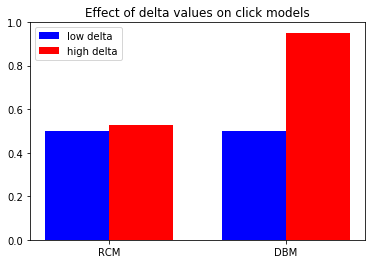

In [11]:
# Effect of different values for delta on 
# create new dict with all values for which delta is positive
pairs_dict = {}
for key, value in delta_values.items():
    avg = sum(value, 0.0)/len(value)
    if avg > 0.0:
        pairs_dict[key] = avg

keys = sorted(pairs_dict, key=pairs_dict.get)

index = round(len(pairs_dict)/10)
# take first 10 % of the sorted dictionary to represent the low delta values
low_deltas = keys[:index]

# take last 10 % of the sorted dictionary to represent the high delta values
high_deltas = keys[-index:]

# interleave both pair lists
low_delta_results, low_delta_origins = interleaving(low_deltas)
high_delta_results, high_delta_origins = interleaving(high_deltas)

# get rho out of data
f=open("YandexRelPredChallenge.txt","r")
rho = learn_param_RCM(f)
f.close()

# get sigma out of data                     
f=open("YandexRelPredChallenge.txt","r")
sigma = learn_param_DBM(f)
f.close()

# run N simulations
N = 50

# run the random click model on both delta's
p_RCM_ld = RCM_simulation(low_delta_results, low_delta_origins, rho, N)
p_RCM_hd = RCM_simulation(high_delta_results, high_delta_origins, rho, N)

# run the dynamic bayesion model on both delta's
p_DBM_ld = DBM_simulation(low_delta_results, low_delta_origins, sigma, N)
p_DBM_hd = DBM_simulation(high_delta_results, high_delta_origins, sigma, N)

# run statistical tests to find significant differences
scipy.stats.ttest_ind(p_DBM_ld, p_DBM_hd)

####### CREATE PLOT ########

multiple_bars = plt.figure()

x = [0.25,0.8]
names = ['RCM', 'DBM']

bars_RCM = [sum(p_RCM_ld)/len(p_RCM_ld), sum(p_DBM_ld)/len(p_DBM_ld)]
bars_DBM = [sum(p_RCM_hd)/len(p_RCM_hd), sum(p_DBM_hd)/len(p_DBM_hd)]

ax = plt.subplot(111)

ax.bar(x[0]-0.1, bars_RCM[0] ,width=0.2,color='b',align='center', label = 'low delta')
ax.bar(x[0]+0.1, bars_RCM[1] ,width=0.2,color='r',align='center', label = 'high delta')

ax.bar(x[1]-0.1, bars_DBM[0] ,width=0.2,color='b',align='center')
ax.bar(x[1]+0.1, bars_DBM[1] ,width=0.2,color='r',align='center')
ax.set_xticks([x[0],x[1]])
ax.set_xticklabels(names)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.set_title('Effect of delta values on click models')

plt.show()



Figure ?: Effect of delta values on click models. This figure shows the proportion of times where algorithm E provided more links that were clicked than algorithm P in a ranking. The blue bars represent 10% of the delta values where E outperforms P  just slightly (lowest delta values). The red bars represent 10% of the delta values where E outperforms P more clearly (highest delta values). The delta values where calculated by taking the mean of all results of the offline measures per pair. 

From this figure can be concluded that the models as well as the offline metrics seem to work. Pairs are extracted based on their delta measure. Pairs are only considered if E outperforms P (resulting in extraction of all positive delta values). The higher the delta value, the more E outperforms P, meaning the more relevant documents will be provided by E in comparison with P. We thus expected to find differences in only our dynamic bayesian model based on these delta values. For the random click model we did not expect to find any differences, since the probability of clicking on a document does not depend in any way on the relevance of a document. Thus, the manner in which E outperform P (meaning having more relevant documents in an interleaved ranking) will not have any effect on what is clicked.
For the dynamic bayesian model (DBM), we did expect to find differences caused by the difference in delta values. We based this expectation on the fact that in a DBM, relevance has an impact on click probability. Therefore, algorithms that provide more relevant documents in comparison to other algorithms in a ranking will be more likely to win (provide more documents that are clicked on). This effect can be found in the figure above, which shows that within the DBM, E wins by a larger margin if it provides more relevant documents in comparison to P (thus having a larger delta value for the offline measures) . If E outperforms P just slightly (by having a low delta value), E is not more likely to provide more documents that were clicked on, since the algorithms provide roughly the same amount of relevant documents. These results confirm that our offline measures calculate their delta in such a way that it has a high value for pairs where E outperforms P by a large margin and a low valuje for pairs where E outperforms P by a small margin. Moreover, we can conclude that our click models seem to work based on the assumptions that we made beforehand and the results shown in this figure. The RCM is not affected by difference in relevance of provided documents, while the DBM shows that an algorithm that provides relatively more relevant documents is more likely to win (provide more documents that area clicked) than an algorithm that provides relatively less relevant documents.

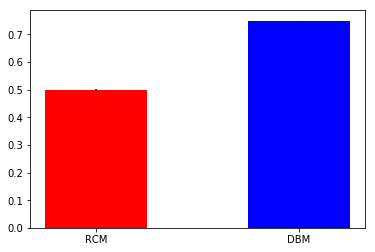

In [12]:
##### PLOT OVER THE AVERAGE OF ALL METRICS #####

# average over all metrics and standard deviation for random click model
avg_ALL_RCM = statistics.mean(p_RCM_list)
stdev_ALL_RCM = statistics.pstdev(p_RCM_list)

# average over all metrics and standard deviation for dynamic bayesian model
avg_ALL_DBM = statistics.mean(p_DBM_list)
stdev_ALL_DBM = statistics.pstdev(p_DBM_list)

# plot bar graph over all metrics, RCM compared to DBM
ax = plt.gca()

x = range(1, 3)
y = (avg_ALL_RCM, avg_ALL_DBM)
z = (stdev_ALL_RCM, stdev_ALL_DBM)
names = ('RCM', 'DBM')
clr = ('r', 'b')
plt.bar(x, y, width=0.5, color = clr, yerr = z, align="center")

ind = range(1, 3)
plt.xticks(ind, x)
ax.set_xticklabels(names)
plt.show()

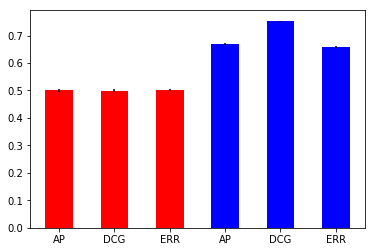

In [13]:
##### PLOTS FOR EACH METRIC #####

# average and standard deviation per metric for random click model
avg_AP_RCM = statistics.mean(p_AP_RCM_list)
stdev_AP_RCM = statistics.pstdev(p_AP_RCM_list)

avg_DCG_RCM = statistics.mean(p_DCG_RCM_list)
stdev_DCG_RCM = statistics.pstdev(p_DCG_RCM_list)

avg_ERR_RCM = statistics.mean(p_ERR_RCM_list)
stdev_ERR_RCM = statistics.pstdev(p_ERR_RCM_list)

# average and standard deviation per metric for random click model
avg_AP_DBM = statistics.mean(p_AP_DBM_list)
stdev_AP_DBM = statistics.pstdev(p_AP_DBM_list)

avg_DCG_DBM = statistics.mean(p_DCG_DBM_list)
stdev_DCG_DBM = statistics.pstdev(p_DCG_DBM_list)

avg_ERR_DBM = statistics.mean(p_ERR_DBM_list)
stdev_ERR_DBM = statistics.pstdev(p_ERR_DBM_list)


# plot bar graph over all metrics, RCM compared to DBM
ax = plt.gca()

x = range(1, 7)
y = (avg_AP_RCM, avg_DCG_RCM, avg_ERR_RCM, avg_AP_DBM, avg_DCG_DBM, avg_ERR_DBM)
z = (stdev_AP_RCM, stdev_DCG_RCM, stdev_ERR_RCM, stdev_AP_DBM, stdev_DCG_DBM, stdev_ERR_DBM)
names = ('AP', 'DCG', 'ERR', 'AP', 'DCG', 'ERR')
clr = ('r', 'r', 'r', 'b', 'b', 'b')
plt.bar(x, y, width=0.5, color = clr, yerr = z, align="center")

ind = range(1, 7)
plt.xticks(ind, x)
ax.set_xticklabels(names)
plt.show()

Below, you can find the percentages of co-occurent pairs between the offline evaluation measures. We find that a high percentage of overlapping pairs seems to correlate to a higher performace of this evaluation measure. We assume that pairs found by only a single measure have a higher chance of being misclassified and thus decrease performance.

In [15]:
##### Check percentages of overlapping pairs between offline measures #####,

print("AP:",len(AP_pairs))
print("DCG:",len(DCG_pairs))
print("ERR:",len(ERR_pairs))

print("---")

print("AP in DCG:", len(list(set(AP_pairs).intersection(DCG_pairs)))/len(AP_pairs))
print("AP in ERR:", len(list(set(AP_pairs).intersection(ERR_pairs)))/len(AP_pairs))
print("DCG in AP:", len(list(set(DCG_pairs).intersection(AP_pairs)))/len(DCG_pairs))
print("DCG in ERR:", len(list(set(DCG_pairs).intersection(ERR_pairs)))/len(DCG_pairs))
print("ERR in AP:", len(list(set(ERR_pairs).intersection(AP_pairs)))/len(ERR_pairs))
print("ERR in DCG:", len(list(set(ERR_pairs).intersection(DCG_pairs)))/len(ERR_pairs))


AP: 27954
DCG: 29376
ERR: 29025
---
AP in DCG: 0.7894040208914646
AP in ERR: 0.6827645417471561
DCG in AP: 0.7511914488017429
DCG in ERR: 0.7144607843137255
ERR in AP: 0.6575710594315245
ERR in DCG: 0.7231007751937985


Through our test of the evaluation measures, we find that ERR has the worst performance. A likely cause of this relatively poor performance is the assumption of independence between queries and documents. ERR is an algorithm designed specifically to tackle the downsides of this assumption and is thus likely to perform better in a real-world application.